In [407]:
#from datetime import datetime, timedelta
#from iexfinance.stocks import get_historical_data
#from iexfinance.refdata import get_symbols
import os
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
import hvplot.pandas
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.express as px
import seaborn as sns
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt

In [2]:
#import clustering data
sp500_fundamentals = pd.read_csv("Data/Fundamentals_Clustering_12-6-2019.csv")
#sp500_fundamentals = pd.read_csv("Data/company_fundamentals.csv")
sp500_fundamentals = sp500_fundamentals.dropna()
sp500_fundamentals['Ticker'] = sp500_fundamentals.Ticker.apply(lambda x: x[x.find(":")+1:])
sp500_fundamentals = sp500_fundamentals[sp500_fundamentals.IQ_PE_EXCL!='(Invalid Identifier)']

In [3]:
#keep nessessary columns
colnames_keep = sp500_fundamentals.columns[1:]
#colnames_keep =['Ticker', 'PE_Calc', 'Return on Equity_Calc', 'IQ_BETA_2YR']
sp500_fundamentals = sp500_fundamentals[colnames_keep]

In [4]:
#replace 0 and NM values with NA
sp500_fundamentals = sp500_fundamentals.replace("0", np.nan)
sp500_fundamentals = sp500_fundamentals.replace("NM", np.nan)
#sp500_fundamentals = sp500_fundamentals.replace("#DIV/0!", np.nan)


In [5]:
#import industry data
#sp500_industry = pd.read_csv("Data/industry.csv")
sp500_industry = pd.read_csv("Data/s_universe.csv")
#sp500_industry['Ticker'] = sp500_industry.Ticker.apply(lambda x: x[x.find(":")+1:])
sp500_industry.rename(columns={"SPX 8/7/2018":'Ticker'}, inplace=True)
sp500_industry['Ticker'] = sp500_industry.Ticker.str[:-10]
sp500_industry = sp500_industry[['Ticker', 'GICS_SECTOR_NAME']]

In [6]:
#merge industry data and fundamental data
sp500 = pd.merge(sp500_fundamentals, sp500_industry, on="Ticker")
#sp500 = pd.get_dummies(sp500, columns=['Industry'])
labels = sp500['GICS_SECTOR_NAME'].astype('category').cat.categories.tolist()
replace_map_comp = {'GICS_SECTOR_NAME' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}
sp500.replace(replace_map_comp, inplace=True)

In [7]:
#get market cap data
sp500_market_cap = pd.read_csv("Data/company_fundamentals.csv")
sp500_market_cap = sp500_market_cap[['Ticker', 'IQ_MarketCap']]
sp500_market_cap['Ticker'] = sp500_market_cap.Ticker.apply(lambda x: x[x.find(":")+1:])
sp500_market_cap.shape

(500, 2)

In [8]:
#merge market cap data
sp500_all = pd.merge(sp500, sp500_market_cap, on="Ticker")
sp500_all.head()

,Ticker,IQ_PE_EXCL,IQ_PE_NORMALIZED,IQ_PBV,IQ_TOTAL_DEBT_EQUITY,IQ_TOTAL_DEBT_CAPITAL,IQ_NI_MARGIN,IQ_NI_NORM_MARGIN,IQ_RETURN_COMMON_EQUITY,IQ_RETURN_ASSETS,IQ_BETA_2YR,IQ_BETA_5YR,GICS_SECTOR_NAME,IQ_MarketCap
0,AAPL,22.76787,30.61689,13.29268,119.4047,54.4221,21.238,15.799,55.9172,11.3473,1.11336,1.22827,8,1.203103e+06
1,MSFT,28.63205,41.02506,10.92258,80.6799,44.6535,31.656,22.0517,42.8,10.6439,1.0719,1.23047,8,1.157290e+06
2,AMZN,77.61561,105.62703,15.3437,132.0007,56.8966,4.2743,3.1373,23.7303,5.2185,1.36685,1.51647,2,8.670105e+05
3,FB,32.1421,39.21898,6.10429,9.7149,8.8547,27.0829,22.1839,20.6698,13.2268,1.21337,1.06229,1,5.767943e+05
4,JPM,13.33257,16.55956,1.79455,NaN,NaN,32.5291,24.8785,14.21,1.3002,1.10356,1.21855,5,4.207901e+05


In [115]:
#sp500_all = sp500_all.drop(columns="GICS_SECTOR_NAME")

In [9]:
#fill NAs
def deal_with_na (df, method):
    if method == "ml":
        #drop first column
        first_colname = df.columns[0]
        df = df.drop(columns=first_colname)
        df = df.astype('float')
        #drop rows with more than 2 NAs
        df = df.dropna(thresh=df.shape[1]-1)
        tickers = df.iloc[:,0].to_frame()
        data_without_null = df.dropna() 
        for i in range(0, df.shape[1]):
            print(df.columns[i])
            colname = df.columns[i]
            X_train = data_without_null.drop(columns=[colname])
            y_train = data_without_null[colname]
            X_test = df[df[colname].isnull()].drop(columns=[colname])
            if X_test.shape[0] != 0:
                linreg = LinearRegression()
                linreg.fit(X_train, y_train)
                predicted = linreg.predict(X_test)
                df[colname][df[colname].isnull()] = predicted
        output = pd.concat([tickers, df], axis=1)
        return output
    if method == "ts":
        #drop first column
        tickers = df.iloc[:,0].to_frame()
        first_colname = df.columns[0]
        df = df.drop(columns=first_colname)
        df = df.astype('float')
        for i in range(0, df.shape[1]):
            colname = df.columns[i]
            colmean = df[colname].median()
            df[colname]=df[colname].fillna(colmean)
        output = pd.concat([tickers, df], axis=1)
        return output
        

In [10]:
#sp500_no_na = deal_with_na(sp500_fundamentals, 'ml')
#sp500_no_na = deal_with_na(sp500_fundamentals, 'ts')
#sp500_no_na = sp500_fundamentals.dropna()

#sp500_no_na = deal_with_na(sp500_all, 'ml')
sp500_no_na = deal_with_na(sp500_all, 'ts')
#sp500_no_na = sp500_all.dropna()

#sp500_no_na = deal_with_na(sp500, 'ml')
#sp500_no_na = deal_with_na(sp500, 'ts')
#sp500_no_na = sp500.dropna()
sp500_no_na.head()

,Ticker,IQ_PE_EXCL,IQ_PE_NORMALIZED,IQ_PBV,IQ_TOTAL_DEBT_EQUITY,IQ_TOTAL_DEBT_CAPITAL,IQ_NI_MARGIN,IQ_NI_NORM_MARGIN,IQ_RETURN_COMMON_EQUITY,IQ_RETURN_ASSETS,IQ_BETA_2YR,IQ_BETA_5YR,GICS_SECTOR_NAME,IQ_MarketCap
0,AAPL,22.76787,30.61689,13.29268,119.4047,54.4221,21.2380,15.7990,55.9172,11.3473,1.11336,1.22827,8.0,1.203103e+06
1,MSFT,28.63205,41.02506,10.92258,80.6799,44.6535,31.6560,22.0517,42.8000,10.6439,1.07190,1.23047,8.0,1.157290e+06
2,AMZN,77.61561,105.62703,15.34370,132.0007,56.8966,4.2743,3.1373,23.7303,5.2185,1.36685,1.51647,2.0,8.670105e+05
3,FB,32.14210,39.21898,6.10429,9.7149,8.8547,27.0829,22.1839,20.6698,13.2268,1.21337,1.06229,1.0,5.767943e+05
4,JPM,13.33257,16.55956,1.79455,91.9962,49.5477,32.5291,24.8785,14.2100,1.3002,1.10356,1.21855,5.0,4.207901e+05


In [11]:
sp500_kmeans = sp500_no_na.iloc[:,1:]
sp500_kmeans['IQ_MarketCap'] = sp500_kmeans['IQ_MarketCap'].apply(np.log)
sp500_scaled = StandardScaler().fit_transform(sp500_kmeans)

In [12]:
inertia = []
k = list(range(1, 11))
for i in k:
    km = KMeans(n_clusters=i)
    km.fit(sp500_scaled)
    inertia.append(km.inertia_)

elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)
df_elbow.hvplot.line(x="k", y="inertia", xticks=k, title="Elbow Curve")

:Curve   [k]   (inertia)

In [13]:
model = KMeans(n_clusters=8)
model.fit(sp500_scaled)
predictions = model.predict(sp500_scaled)
predictions = pd.DataFrame(predictions)
predictions.rename(columns={0:'predictions'}, inplace=True)

#predictions = sp500_all['GICS_SECTOR_NAME'].to_frame()
#predictions.rename(columns={'GICS_SECTOR_NAME':'predictions'}, inplace=True)




In [14]:
#sp500_all.shape
sp500_no_na.shape

(464, 14)

In [48]:
output = pd.concat([sp500_no_na, predictions], axis=1)
output.to_csv("Data/clusters.csv", index=False)

In [15]:
#sp500_scaled = StandardScaler().fit_transform(sp500_kmeans)
pca = PCA(n_components=6)
sp500_pca = pca.fit_transform(sp500_scaled)
pca.explained_variance_ratio_

array([0.17260432, 0.1569816 , 0.13037777, 0.11394324, 0.08566481,
       0.06906775])

In [16]:
sp500_pca = pd.DataFrame(
    data=sp500_pca, columns=["pc1", "pc2", 'pc3', 'pc4', 'pc5', 'pc6']
)

sp500_pca_pred = pd.concat([sp500_pca, predictions], axis=1)
sp500_pca_pred.hvplot.scatter(x='pc1', y='pc2', by='predictions', width=800, height=600)

:NdOverlay   [predictions]
   :Scatter   [pc1]   (pc2)

In [ ]:
fig = px.scatter_3d(sp500_pca_pred, x='pc1', y='pc2', z='pc3', color='predictions')
fig.show()

For n_clusters = 2 The average silhouette_score is : 0.20687147394743238
For n_clusters = 3 The average silhouette_score is : 0.15304597372804163
For n_clusters = 4 The average silhouette_score is : 0.1573963661201103
For n_clusters = 5 The average silhouette_score is : 0.17039301085507955
For n_clusters = 6 The average silhouette_score is : 0.17564527716996656
For n_clusters = 7 The average silhouette_score is : 0.18081338642951644
For n_clusters = 8 The average silhouette_score is : 0.1858422572134909


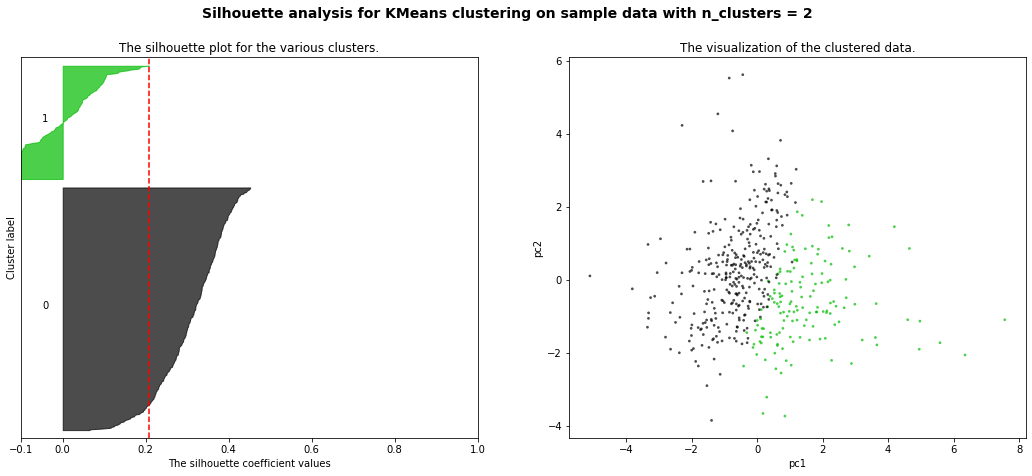

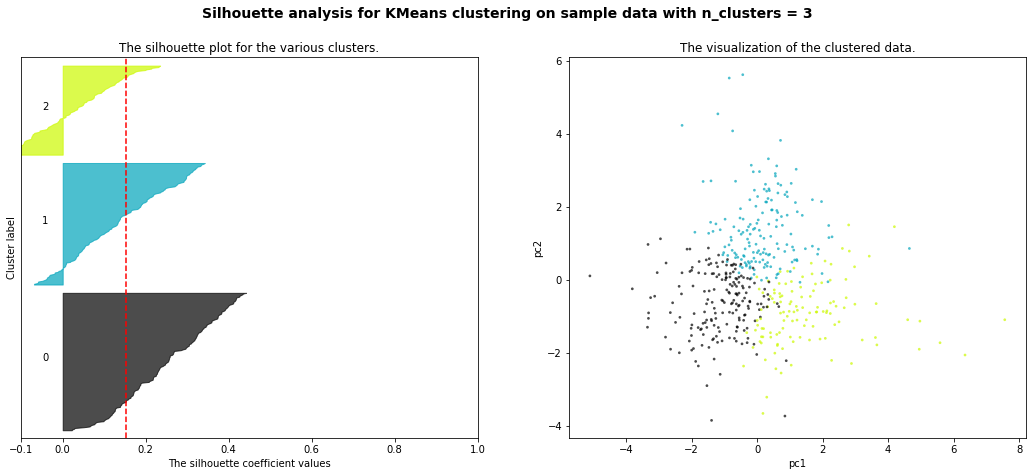

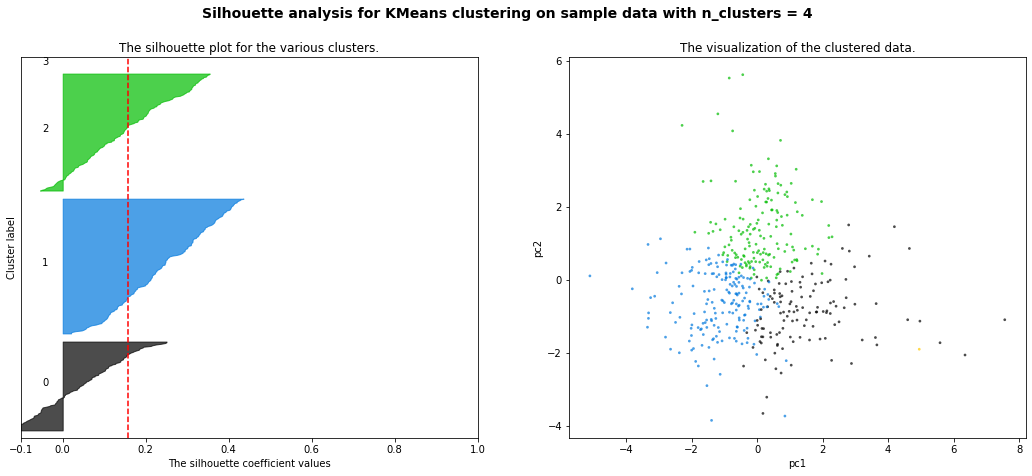

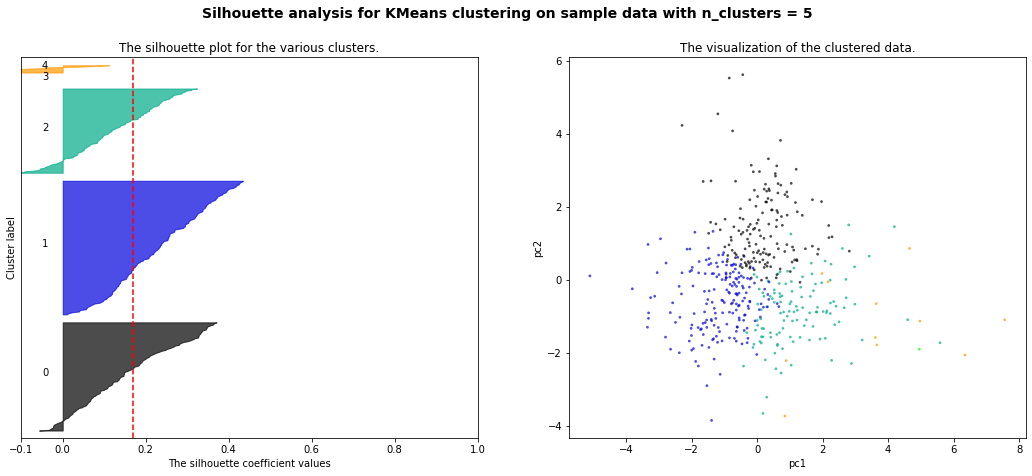

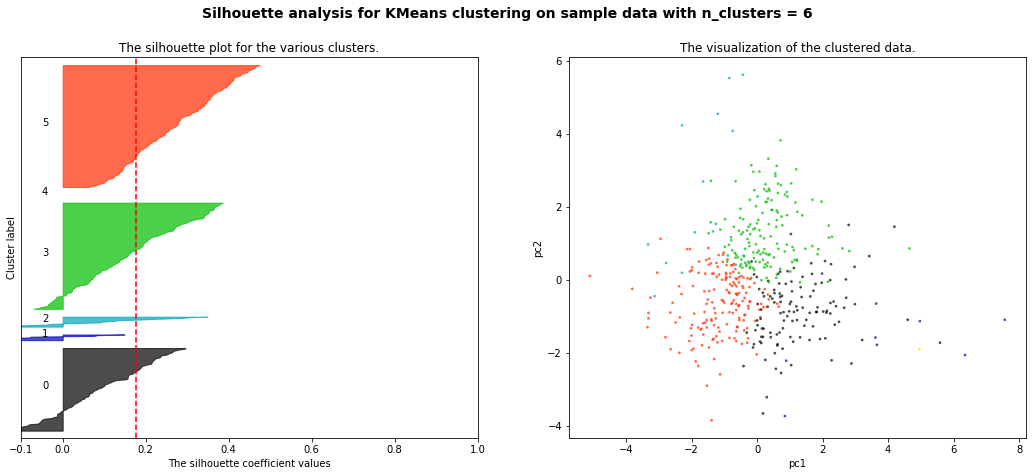

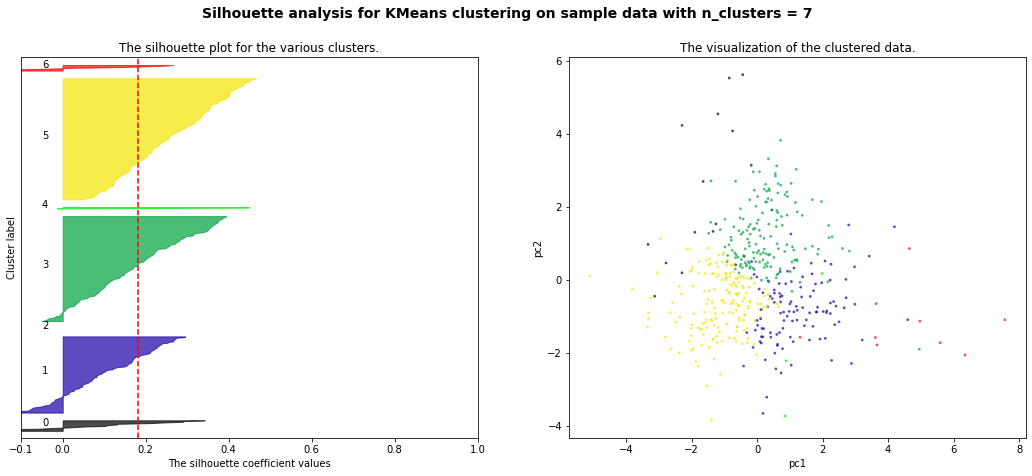

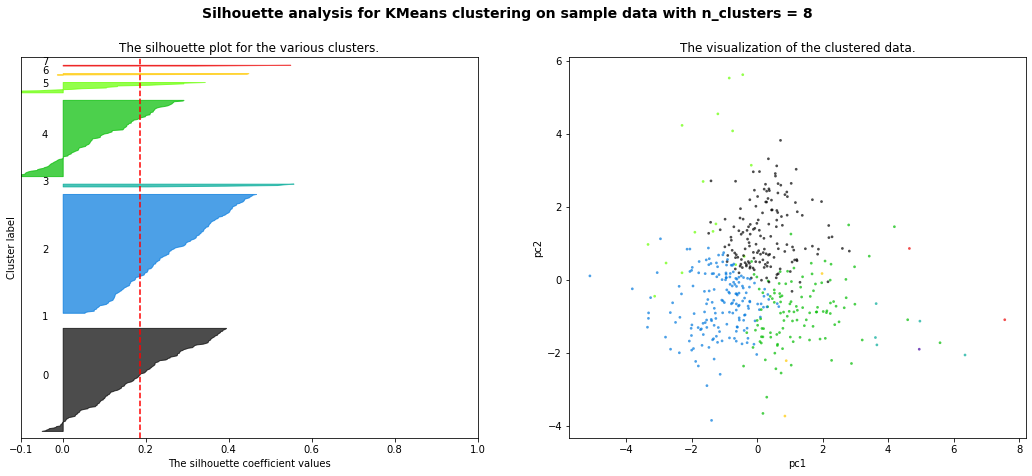

In [122]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(sp500_scaled) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters)
    cluster_labels = clusterer.fit_predict(sp500_scaled)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(sp500_scaled, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(sp500_scaled, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(sp500_pca_pred.iloc[:, 0], sp500_pca_pred.iloc[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    #ax2.scatter(centers[:, 0], centers[:, 1], marker='o',c="white", alpha=1, s=200, edgecolor='k')

    #for i, c in enumerate(centers):
        #ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("pc1")
    ax2.set_ylabel("pc2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    file_name = "Figure/Silhouette_no_industry_" + str(n_clusters) + ".png"
    plt.savefig(file_name)

In [480]:
#import clusters
clusters = pd.read_csv("Data/clusters.csv")
clusters.groupby('predictions').Ticker.count().to_frame().rename(columns={'Ticker':'Counts'})
#remove clusters
mask1 = clusters['predictions']!=4
mask2 = clusters['predictions']!=6
mask = mask1 & mask2
clusters = clusters[mask]


In [481]:
#import stock prices
stock_prices = pd.read_csv("Data/s_PX.csv", index_col="Date", parse_dates=True, infer_datetime_format=True)
#stock_prices = stock_prices.dropna()
stock_prices.columns = stock_prices.columns.str[:-10]
stock_prices = stock_prices.loc['2000-12-10':'2019-12-10'].dropna(how="all")

In [482]:
df_price=pd.read_csv("prices.csv")
df_price.set_index(pd.to_datetime(df_price['Date'], infer_datetime_format=True), inplace=True)
df_price.drop(columns=['Date','XLE US Equity', 'XLF US Equity', 'XLI US Equity',
       'XLK US Equity', 'XLP US Equity', 'XLRE US Equity', 'XLU US Equity',
       'XLV US Equity', 'XLY US Equity','XLB US Equity'], inplace=True)
df_price = df_price.loc['2000-12-10':'2019-12-10']

# Reading price data from stocks - monthly
s_price_m=df_price.copy()
s_price_m=s_price_m.groupby([s_price_m.index.year, s_price_m.index.month]).tail(1)
ret_sp = s_price_m.pct_change()
ret_sp = ret_sp.dropna(how='all')
ret_sp

,SPXT Index
Date,
2001-01-31,0.035475
2001-02-28,-0.091178
2001-03-30,-0.063352
2001-04-30,0.077707
2001-05-31,0.006703
...,...
2019-08-30,-0.015841
2019-09-30,0.018711
2019-10-31,0.021659


cluster size: 131
131
dataframe size: 103
cluster size: 114
114
dataframe size: 77
cluster size: 131
131
dataframe size: 88
cluster size: 65
65
dataframe size: 57
cluster size: 8
8
dataframe size: 7
cluster size: 11
11
dataframe size: 5


,0,1,2,3,5,7
2001-01-31,-0.042921,0.060219,0.059265,-0.062670,-0.010051,0.088032
2001-02-28,-0.056187,-0.088345,-0.080577,0.004317,-0.159483,-0.108334
2001-03-30,-0.032919,-0.071864,-0.054337,-0.042555,-0.115951,-0.239517
2001-04-30,0.054072,0.104461,0.104350,0.070274,0.186510,0.345431
2001-05-31,0.017829,0.024134,0.026488,0.011630,0.026655,-0.169456
...,...,...,...,...,...,...
2019-08-30,-0.028802,-0.010903,-0.040178,0.042206,0.024940,-0.000215
2019-09-30,-0.012950,0.026416,0.046442,0.019935,-0.028760,-0.015025
2019-10-31,0.015222,0.048422,0.022156,-0.006306,0.046834,0.002452
2019-11-29,0.024527,0.042575,0.039167,-0.009683,0.007352,0.077649


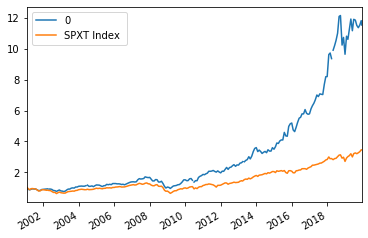

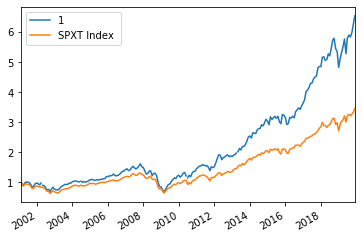

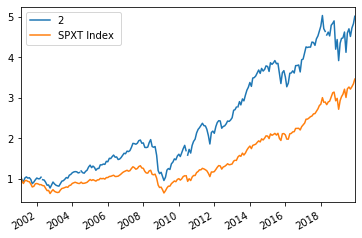

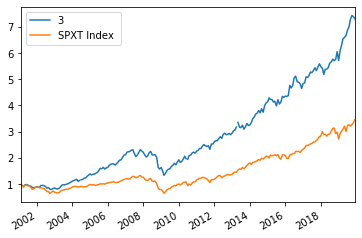

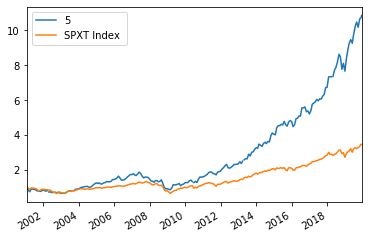

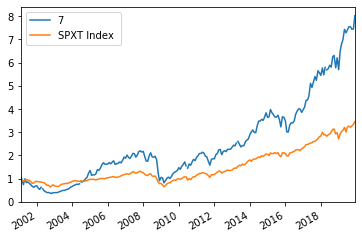

In [498]:
pred = [0,1,2,3,5,7]
cluster_indices = pd.DataFrame()
for cluster in pred:
    tickers = clusters[clusters['predictions']==cluster].Ticker.tolist()
    print(f"cluster size: {len(tickers)}")
    tickers_df = pd.DataFrame(columns=tickers)
    cluster_sp = pd.concat([tickers_df,stock_prices], axis=0, join="inner")
    print(cluster_sp.shape[1])
    cluster_sp_no_na = cluster_sp.dropna(axis=1)
    print(f"dataframe size: {cluster_sp_no_na.shape[1]}")
    #cluster_sp_no_na_m = cluster_sp_no_na.groupby([cluster_sp_no_na.index.year, cluster_sp_no_na.index.month]).tail(1)
    #cluster_sp_no_na_m_change = cluster_sp_no_na_m.pct_change().dropna()
    #cluster_price_change = cluster_sp_no_na_m_change.mean(axis = 1).to_frame().rename(columns = {0:cluster})
    colnames = cluster_sp_no_na.columns.to_frame().rename(columns={0:"Ticker"})
    marketcap = pd.merge(colnames, clusters, on="Ticker")[['IQ_MarketCap']].astype("float")
    marketcap_weight = (marketcap/marketcap.sum()).IQ_MarketCap.tolist()
    cluster_price = cluster_sp_no_na.dot(marketcap_weight).to_frame().rename(columns={0:cluster})
    cluster_price_m = cluster_price.groupby([cluster_price.index.year, cluster_price.index.month]).tail(1)
    cluster_price_change = cluster_price_m.pct_change().dropna()
    cluster_sp500 = pd.concat([cluster_price_change, ret_sp], axis = 1, join = 'outer')
    cluster_sp500 = (1+cluster_sp500).cumprod()    
    filename = "Figure/cluster_" + str(cluster) + "_sp500.png"
    plt = cluster_sp500.plot()
    fig = plt.get_figure()
    fig.savefig(filename)
    cluster_indices = pd.concat([cluster_indices,cluster_price_change], axis=1)
cluster_indices

In [455]:
#cluster_indices = cluster_indices.groupby([cluster_indices.index.year, cluster_indices.index.month]).tail(1)
#cluster_indices

,0,1,2,3,5,7
2000-12-29,29.262572,26.377670,23.033739,16.000353,23.391208,17.452581
2001-01-31,28.006580,27.966103,24.398843,14.997606,23.156107,18.988975
2001-02-28,26.432976,25.495441,22.432857,15.062358,19.463096,16.931822
2001-03-30,25.562827,23.663230,21.213915,14.421376,17.206322,12.876368
2001-04-30,26.945055,26.135125,23.427580,15.434822,20.415469,17.324263
...,...,...,...,...,...,...
2019-08-30,336.773012,153.809739,103.874189,116.620409,245.036441,131.735257
2019-09-30,332.411846,157.872710,108.698286,118.945238,237.989085,129.755990
2019-10-31,337.471926,165.517287,111.106562,118.195155,249.135036,130.074090
2019-11-29,345.749268,172.564115,115.458300,117.050623,250.966648,140.174238


In [456]:
cluster_indices.to_csv("Data/cluster_index_prices.csv")

In [484]:
s_price = pd.read_csv("Resources/s_PX.csv", index_col="Date", parse_dates=True, infer_datetime_format=True)
s_price.columns = s_price.columns.str[:-10]
s_price = s_price.loc['2000-12-10':'2019-12-10'].dropna(how="all")
s_price_m=s_price.groupby([s_price.index.year, s_price.index.month]).tail(1)
s_ret = s_price.pct_change()
s_ret = s_ret.dropna(how='all')

In [485]:
s_ret_m = s_price_m.pct_change()
s_ret_m=s_ret_m.shift(-1)

In [ ]:
#df = s_ret_m.quantile(2/3, axis=1)
#out_performers = pd.DataFrame(np.where(s_ret_m.gt(df, axis=0), 1, 0), columns = s_ret_m.columns, index = s_ret_m.index)
#df2 = s_ret_m.quantile(1/3, axis=1)
#under_performers = pd.DataFrame(np.where(s_ret_m.lt(df2, axis=0), -1, 0), columns = s_ret_m.columns, index = s_ret_m.index)
#df_ylabel = out_performers + under_performers
#df_ylabel

In [486]:
s_mkt = pd.read_csv("Resources/s_MarketCap.csv", index_col="Date", parse_dates=True, infer_datetime_format=True)
s_mkt.columns = s_mkt.columns.str[:-10]
s_mkt = s_mkt.loc['2000-12-10':'2019-12-10'].dropna(how="all")
s_mkt.shape

(228, 505)

In [502]:
#calculate technical indicators
window_year=252
window_month=21
window_quarter=63

s_feat1=s_price/s_price.shift(window_year)-1 #Price momentum 12M 
s_feat2=s_price.shift(window_month)/s_price.shift(window_year)-1 #Price momentum 12M-1M 
s_feat3=s_price/s_price.rolling(window_year).max() #Price to 52W High 
s_feat4=s_price/s_price.rolling(window_year).min() #Price to 52W low 
s_feat5=s_price/s_price.shift(window_month)-1 #Return 1M
s_feat6=s_price/s_price.shift(window_quarter)-1 #Return 1Q
#s_feat7=s_price/s_price.shift(window_year*5)-1 #Return 60M
s_feat8=s_ret.rolling(window_month).max() #Maximum daily return over 1M
s_feat9=s_ret.rolling(window_month).std() #Realized vol 1M
s_feat10=s_ret.rolling(window_quarter).std() #Realized vol 3M
s_feat11=np.log(s_mkt) #Log Market capitalization - already monthly

s_feat1=s_feat1.groupby([s_feat1.index.year, s_feat1.index.month]).tail(1)
s_feat2=s_feat2.groupby([s_feat2.index.year, s_feat2.index.month]).tail(1)
s_feat3=s_feat3.groupby([s_feat3.index.year, s_feat3.index.month]).tail(1)
s_feat4=s_feat4.groupby([s_feat4.index.year, s_feat4.index.month]).tail(1)
s_feat5=s_feat5.groupby([s_feat5.index.year, s_feat5.index.month]).tail(1)
s_feat6=s_feat6.groupby([s_feat6.index.year, s_feat6.index.month]).tail(1)
#s_feat7=s_feat7.groupby([s_feat7.index.year, s_feat7.index.month]).tail(1)
s_feat8=s_feat8.groupby([s_feat8.index.year, s_feat8.index.month]).tail(1)
s_feat9=s_feat9.groupby([s_feat9.index.year, s_feat9.index.month]).tail(1)
s_feat10=s_feat10.groupby([s_feat10.index.year, s_feat10.index.month]).tail(1)

In [507]:
y_stacked = s_feat1.stack(dropna=False).to_frame().rename(columns={0: 'p_momentum_12M'})

df_stacked1 = s_feat2.stack(dropna=False).to_frame().rename(columns={0: 'p_momentum_12M-1M'})
y_stacked = pd.concat([y_stacked, df_stacked1], axis = 1, join="outer")

df_stacked1 = s_feat3.stack(dropna=False).to_frame().rename(columns={0: 'price_52w_high'})
y_stacked = pd.concat([y_stacked, df_stacked1], axis = 1, join="outer")

df_stacked1 = s_feat4.stack(dropna=False).to_frame().rename(columns={0: 'price_52w_low'})
y_stacked = pd.concat([y_stacked, df_stacked1], axis = 1, join="outer")

df_stacked1 = s_feat5.stack(dropna=False).to_frame().rename(columns={0: 'return_1M'})
y_stacked = pd.concat([y_stacked, df_stacked1], axis = 1, join="outer")

df_stacked1 = s_feat6.stack(dropna=False).to_frame().rename(columns={0: 'return_1Q'})
y_stacked = pd.concat([y_stacked, df_stacked1], axis = 1, join="outer")

#df_stacked1 = s_feat7.stack(dropna=False).to_frame().rename(columns={0: 'return_60M'})
#y_stacked = pd.concat([y_stacked, df_stacked1], axis = 1, join="outer")

df_stacked1 = s_feat8.stack(dropna=False).to_frame().rename(columns={0: 'max_daily_1M'})
y_stacked = pd.concat([y_stacked, df_stacked1], axis = 1, join="outer")

df_stacked1 = s_feat9.stack(dropna=False).to_frame().rename(columns={0: 'std_1M'})
y_stacked = pd.concat([y_stacked, df_stacked1], axis = 1, join="outer")

df_stacked1 = s_feat10.stack(dropna=False).to_frame().rename(columns={0: 'std_3M'})
y_stacked = pd.concat([y_stacked, df_stacked1], axis = 1, join="outer")

df_stacked1 = s_feat11.stack(dropna=False).to_frame().rename(columns={0: 'mkt_cap'})
y_stacked = pd.concat([y_stacked, df_stacked1], axis = 1, join="outer")

y_stacked.index.names = ['Date', 'Company']

In [508]:
file_name = ['s_PE.csv', 's_PB.csv', 's_GrossMargin.csv', 's_FreeCashFlowEquity.csv', 's_ROA.csv', 's_DebttoEquity.csv', 's_NetIncomeMargin.csv', 's_ROE.csv']   
for each_file in file_name:
    print(each_file)
    path = 'Resources/' + each_file
    df = pd.read_csv(path, index_col="Date", parse_dates=True, infer_datetime_format=True).dropna(how="all")
    df = df.loc['2000-12-10':'2019-12-10']
    df.columns = df.columns.str[:-10]
    suffix = each_file[:-4]
    df_stacked = df.stack(dropna=False).to_frame().rename(columns={0: suffix})
    df_stacked.index.names = ['Date', 'Company']
    #print(df_stacked)
    y_stacked = pd.concat([y_stacked, df_stacked], axis = 1, join="outer")

s_PE.csv
s_PB.csv
s_GrossMargin.csv
s_FreeCashFlowEquity.csv
s_ROA.csv
s_DebttoEquity.csv
s_NetIncomeMargin.csv
s_ROE.csv


In [ ]:
#scale the data
for eachdate in y_stacked.index.get_level_values(0).unique():
    new_df = y_stacked.loc[eachdate]
    scaler = MinMaxScaler()
    new_df_scaled = scaler.fit_transform(new_df)
    y_stacked.loc[eachdate] = new_df_scaled
#y_stacked.loc[y_stacked.index.get_level_values(0)[0]]

In [510]:
y_stacked

p_momentum_12M  p_momentum_12M-1M  price_52w_high  \
Date       Company                                                      
2000-12-29 A                   NaN                NaN             NaN   
           AAL                 NaN                NaN             NaN   
           AAP                 NaN                NaN             NaN   
           AAPL                NaN                NaN             NaN   
           ABBV                NaN                NaN             NaN   
...                            ...                ...             ...   
2019-12-10 XYL            0.457256           0.532384        0.827225   
           YUM            0.426391           0.487503        0.725427   
           ZBH            0.557381           0.599548        0.962789   
           ZION           0.453934           0.527034        0.973002   
           ZTS            0.604383           0.615006        0.924884   

                    price_52w_low  return_1M  return_1Q  max_daily_1M  \
Date       Company                                                      
2000-12-29 A                  NaN        NaN        NaN           NaN   
           AAL                NaN        NaN        NaN           NaN   
           AAP                NaN        NaN        NaN           NaN   
           AAPL               NaN        NaN        NaN           NaN   
           ABBV               NaN        NaN        NaN           NaN   
...                           ...        ...        ...           ...   
2019-12-10 XYL           0.109599   0.175522   0.332912      0.068314   
           YUM           0.068779   0.200062   0.234614      0.089222   
           ZBH           0.223646   0.200768   0.425512      0.174181   
           ZION          0.146005   0.178688   0.545175      0.083863   
           ZTS           0.247224   0.230494   0.403612      0.072197   

                      std_1M    std_3M   mkt_cap      s_PE      s_PB  \
Date       Company                                                     
2000-12-29 A             NaN       NaN  0.686550  0.015386  0.038453   
           AAL           NaN       NaN       NaN       NaN       NaN   
           AAP           NaN       NaN       NaN       NaN       NaN   
           AAPL          NaN       NaN  0.516439  0.008302  0.013484   
           ABBV          NaN       NaN       NaN       NaN       NaN   
...                      ...       ...       ...       ...       ...   
2019-12-10 XYL      0.146936  0.166470       NaN       NaN       NaN   
           YUM      0.095014  0.116650       NaN       NaN       NaN   
           ZBH      0.186575  0.131494       NaN       NaN       NaN   
           ZION     0.141062  0.134033       NaN       NaN       NaN   
           ZTS      0.128234  0.118255       NaN       NaN       NaN   

                    s_GrossMargin  s_FreeCashFlowEquity     s_ROA  \
Date       Company                                                  
2000-12-29 A                  NaN              0.686833  0.576691   
           AAL                NaN              0.683474  0.484376   
           AAP                NaN                   NaN       NaN   
           AAPL               NaN              0.690117  0.503231   
           ABBV               NaN                   NaN       NaN   
...                           ...                   ...       ...   
2019-12-10 XYL                NaN                   NaN       NaN   
           YUM                NaN                   NaN       NaN   
           ZBH                NaN                   NaN       NaN   
           ZION               NaN                   NaN       NaN   
           ZTS                NaN                   NaN       NaN   

                    s_DebttoEquity  s_NetIncomeMargin     s_ROE  
Date       Company                                               
2000-12-29 A              0.000249                NaN  0.727816  
           AAL            0.010396                NaN  0.726702  
           AAP       

0
131
131
131
1
114
114
114
2
131
131
131
3
65
65
65
7
11
11
11


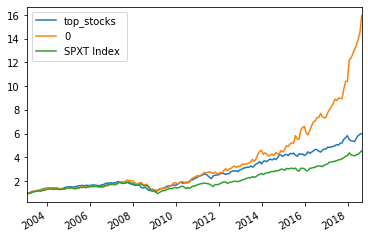

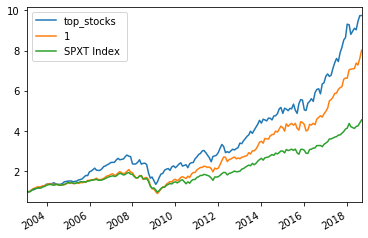

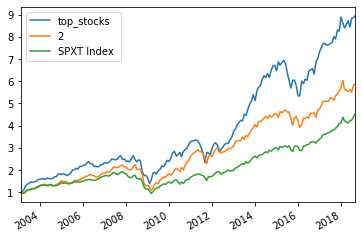

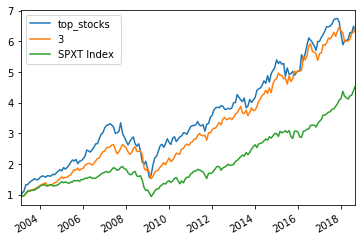

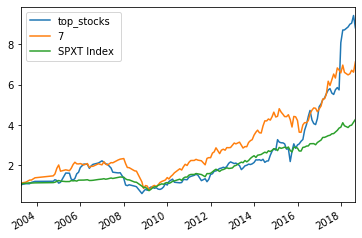

In [512]:
cluster_pctchange = cluster_indices

pred = [0,1,2,3,7]
for cluster_num in pred:
    print(cluster_num)
    indices = cluster_pctchange[[cluster_num]]
    tickers = clusters[clusters['predictions']==cluster_num].Ticker.tolist()
    print(len(tickers))
    ticers_df1 = pd.DataFrame(columns=tickers)
    s_ret_m_cluster = pd.concat([ticers_df1, s_ret_m], axis = 0, join = 'inner')
    df = s_ret_m_cluster.quantile(2/3, axis=1)
    out_performers = pd.DataFrame(np.where(s_ret_m_cluster.gt(df, axis=0), 1, 0), columns = s_ret_m_cluster.columns, index = s_ret_m_cluster.index)
    df2 = s_ret_m_cluster.quantile(1/3, axis=1)
    under_performers = pd.DataFrame(np.where(s_ret_m_cluster.lt(df2, axis=0), -1, 0), columns = s_ret_m_cluster.columns, index = s_ret_m_cluster.index)
    df_ylabel = out_performers + under_performers
    df_ylabel = df_ylabel.stack().to_frame().rename(columns={0: "ylabel"})
    df_ylabel.index.names = ['Date', 'Company']
    tickers_df = pd.DataFrame(index=tickers)
    tickers_df.index.names = ['Company']
    #new_stacked = tickers_df.join(y_stacked, how="inner")
    new_stacked = tickers_df.join(y_stacked, how="inner")
    print(new_stacked.loc[new_stacked.index.get_level_values(0)[0]].shape[0])
    new_stacked = new_stacked.join(df_ylabel, how="right")
    company_num = new_stacked.loc[new_stacked.index.get_level_values(0)[0]].shape[0]
    print(company_num)
    appended_data = pd.DataFrame(columns=['Prediction', 'Actual', 'Probability'])
    feat = []
    new_stacked = new_stacked.reset_index()
    for x in range(12, 200):
        #print(x)
        start_train=(x)*company_num
        end_train=company_num*(x+12)
        end_test=company_num*(x+13)    
        new_stacked1 = new_stacked.drop(columns=['Date', 'Company'])
        train=new_stacked1[start_train:end_train]
        #train.drop(columns=['Date','Company'], inplace=True)
        #train["ylabel"].where((train["ylabel"]!=0) ,np.NaN,inplace=True)
        train = train[train['ylabel']!=0]
        train=train.fillna(0.5)
        test=new_stacked1[end_train:end_test]
        test = test[test['ylabel'] != 0]
        test=test.fillna(0.5)
        y_train = train["ylabel"].values.reshape(-1, 1)
        X_train_scaled=train.copy()
        X_train_scaled.drop(columns=['ylabel'], inplace=True)
        y_test = test["ylabel"].values.reshape(-1, 1)
        X_test_scaled=test.copy()  
        X_test_scaled.drop(columns=['ylabel'], inplace=True)
        learning_rate=1.3
        classifier = GradientBoostingClassifier(n_estimators=20, learning_rate=learning_rate, max_features=5, max_depth=3)
        classifier.fit(X_train_scaled, y_train.ravel())
        predictions = classifier.predict(X_test_scaled)
        predictions_prob = classifier.predict_proba(X_test_scaled)
        df_pred=pd.DataFrame({"Prediction": predictions, "Actual": y_test.ravel() , "Probability": predictions_prob[:, 1]})
        df_pred.index=test.index
        appended_data = pd.concat([appended_data,df_pred])
        temp=classifier.feature_importances_
        feat.append(temp)
    signal = appended_data['Probability'].to_frame()
    signal_all = pd.concat([new_stacked, signal], axis="columns", join="outer").set_index(['Date', 'Company'])[['Probability']]
    signal_all_unstack = signal_all.unstack()
    signal_all_unstack = signal_all_unstack.shift(1)
    N=int(company_num * 0.1)
    df3 = signal_all_unstack.mask(signal_all_unstack.rank(axis=1, method='min', ascending=False) > N, 0)
    df3[df3.isnull()] = 0
    df3[df3 > 0] = 1/N
    df4 = pd.np.multiply(s_ret_m_cluster, df3)
    df4[df4.isnull()] = 0   # nan
    df4=df4.sum(axis=1).to_frame().rename(columns={0:"top_stocks"})
    index_compare = pd.concat([df4, indices], axis = 1, join="inner")
    index_compare = pd.concat([index_compare, ret_sp], axis = 1, join="inner")
    index_compare = index_compare[index_compare.top_stocks!=0]
    index_compare = (1+index_compare).cumprod() 
    filename = "Figure/cluster_" + str(cluster_num) + ".png"
    plt = index_compare.plot()
    fig = plt.get_figure()
    fig.savefig(filename)

In [397]:
appended_data = pd.DataFrame(columns=['Prediction', 'Actual', 'Probability'])
feat = []
x=12
company_num = 131
start_train=(x)*company_num
end_train=company_num*(x+12)
end_test=company_num*(x+13)
new_stacked = new_stacked.reset_index()
new_stacked1 = new_stacked.drop(columns=['Date', 'Company'])

train=new_stacked1[start_train:end_train]
#train.drop(columns=['Date','Company'], inplace=True)
#train["ylabel"].where((train["ylabel"]!=0) ,np.NaN,inplace=True)
train = train[train['ylabel']!=0]
train=train.fillna(0.5)
test=new_stacked1[end_train:end_test]
test = test[test['ylabel'] != 0]
test=test.fillna(0.5)
y_train = train["ylabel"].values.reshape(-1, 1)
X_train_scaled=train.copy()
X_train_scaled.drop(columns=['ylabel'], inplace=True)
y_test = test["ylabel"].values.reshape(-1, 1)
X_test_scaled=test.copy()  
X_test_scaled.drop(columns=['ylabel'], inplace=True)
learning_rate=1
classifier = GradientBoostingClassifier(n_estimators=20, learning_rate=learning_rate, max_features=5, max_depth=3)
classifier.fit(X_train_scaled, y_train.ravel())
predictions = classifier.predict(X_test_scaled)
predictions_prob = classifier.predict_proba(X_test_scaled)
df_pred=pd.DataFrame({"Prediction": predictions, "Actual": y_test.ravel() , "Probability": predictions_prob[:, 1]})
df_pred.index=test.index
appended_data = pd.concat([appended_data,df_pred])
temp=classifier.feature_importances_
feat.append(temp)

#outside loop
signal = appended_data['Probability'].to_frame()
signal_all = pd.concat([new_stacked, signal], axis="columns", join="outer").set_index(['Date', 'Company'])[['Probability']]
signal_all_unstack = signal_all.unstack()
signal_all_unstack = signal_all_unstack.shift(1)
N=int(company_num * 0.1)
df3 = signal_all_unstack.mask(signal_all_unstack.rank(axis=1, method='min', ascending=False) > N, 0)
df3[df3.isnull()] = 0
df3[df3 > 0] = 1/N
df4 = pd.np.multiply(s_ret_m_cluster.shift(1), df3)
df4[df4.isnull()] = 0   # nan
df4=df4.sum(axis=1).to_frame().rename(columns={0:"top_stocks"})
index_compare = pd.concat([df4, indices], axis = 1, join="inner")
index_compare = index_compare[index_compare.top_stocks!=0]
plt = index_compare.plot()
filename = "Figure/cluster_" + cluster_num + ".png"
plt.savefig(filename)

In [398]:
index_compare = index_compare[index_compare.top_stocks!=0]
index_compare

,top_stocks,0
2003-01-31,-0.034904,-0.013232


In [417]:
int(4.8, )

4

In [375]:
signal_all_unstack.rank(axis=1, method='min', ascending=False) < N

             Company
Probability  AAP        0.797295
             ABT             NaN
             ADM             NaN
             AFL        0.926319
             AIG        0.130062
                          ...   
             WLTW            NaN
             WM         0.534369
             WMT             NaN
             XOM             NaN
             XRAY       0.263512
Name: 2002-12-31 00:00:00, Length: 131, dtype: float64

In [ ]:
for eachdate in new_stacked.index.get_level_values(0).unique():
    print(new_stacked.loc[eachdate].shape[0])

In [49]:
pred = [0,1,2,3,5,7]
cluster_pctchange = cluster_indices.pct_change().dropna()
def window_data(df, df2, window_size, colnumber):
    X = []
    y = []
    for i in range(len(df) - window_size):
        features = df.iloc[i : (i + window_size), colnumber]
        target = df2.iloc[(i + window_size), colnumber]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)
    
def window_data2(df, df2, window_size, colnumber):
    X = []
    y = []
    for i in range(len(df) - 2 * window_size):
        features = df.iloc[i : (i + window_size), colnumber]
        rolling = df.iloc[:,colnumber].rolling(window = window_size).mean().dropna()
        X.append(features)
        if rolling[i+window_size] > df2.iloc[i+2*window_size, 0]:
            y.append(1)
        else:
            y.append(0)
    return np.array(X), np.array(y).reshape(-1, 1)   

    
#for cluster in pred:
#    tickers = clusters[clusters['predictions']==cluster].Ticker.tolist()
#    tickers_df = pd.DataFrame(columns=tickers)
#    cluster_sp = pd.concat([tickers_df,stock_prices], axis=0, join="inner")
#    cluster_sp_no_na = cluster_sp.fillna(cluster_sp.median()).dropna(axis=1, how="all").pct_change().dropna() * 100
    

In [50]:
cluster = 0
tickers = clusters[clusters['predictions']==cluster].Ticker.tolist()
tickers_df = pd.DataFrame(columns=tickers)
cluster_sp = pd.concat([tickers_df,stock_prices], axis=0, join="inner")
cluster_sp_no_na = cluster_sp.fillna(cluster_sp.median()).dropna(axis=1, how="all").pct_change().dropna()*100
indices = cluster_pctchange[[cluster]]
column_df = pd.DataFrame(columns = cluster_sp_no_na.columns, index = cluster_sp_no_na.index)
for i in range(0, cluster_sp_no_na.shape[1]):
    column_df.iloc[:,i] = np.where(cluster_sp_no_na.iloc[:,i] > indices.iloc[:,0], 1, 0)
window_size = 5
for i in range(cluster_sp_no_na.shape[1]):
    print(cluster_sp_no_na.columns[i])
    #X, y = window_data(cluster_sp_no_na, column_df, window_size, i)
    X, y = window_data2(cluster_sp_no_na, indices, window_size, i)    
    split = int(0.7 * len(X))
    X_train = X[:split]
    X_test = X[split:]
    y_train = y[:split]
    y_test = y[split:]
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    model = Sequential()
    number_units = window_size
    dropout_fraction = 0.2
    # Layer 1
    model.add(LSTM(
        units=number_units,
        return_sequences=True,
        input_shape=(X_train.shape[1], 1))
        )
    model.add(Dropout(dropout_fraction))
    # Layer 2
    model.add(LSTM(units=number_units, return_sequences=True))
    model.add(Dropout(dropout_fraction))
    # Layer 3
    model.add(LSTM(units=number_units))
    model.add(Dropout(dropout_fraction))
    # Output layer
    model.add(Dense(1))
    # Compile the model
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=20, shuffle=False, batch_size=1, verbose=1)
    model.evaluate(X_test, y_test)

AMZN
Train on 175 samples
Epoch 1/20
175/175 [==============================] - 6s 36ms/sample - loss: 2.2633 - accuracy: 0.4629
Epoch 2/20
175/175 [==============================] - 2s 10ms/sample - loss: 0.9504 - accuracy: 0.4629
Epoch 3/20
175/175 [==============================] - 2s 10ms/sample - loss: 0.7820 - accuracy: 0.4171
Epoch 4/20
175/175 [==============================] - 2s 10ms/sample - loss: 0.7236 - accuracy: 0.5314
Epoch 5/20
175/175 [==============================] - 2s 10ms/sample - loss: 0.7259 - accuracy: 0.5029
Epoch 6/20
175/175 [==============================] - 2s 10ms/sample - loss: 0.7258 - accuracy: 0.5200
Epoch 7/20
175/175 [==============================] - 2s 10ms/sample - loss: 0.7309 - accuracy: 0.4914
Epoch 8/20
175/175 [==============================] - 2s 10ms/sample - loss: 0.7249 - accuracy: 0.5200
Epoch 9/20
175/175 [==============================] - 2s 12ms/sample - loss: 0.6989 - accuracy: 0.5371
Epoch 10/20
175/175 [==========================

KeyboardInterrupt: 

In [21]:
for i in range(0,5):
    print(i)

0
1
2
3
4
